# Visualizing Word Vectors with t-SNE

TSNE is pretty useful when it comes to visualizing similarity between objects. It works by taking a group of high-dimensional (100 dimensions via Word2Vec) vocabulary word feature vectors, then compresses them down to 2-dimensional x,y coordinate pairs. The idea is to keep similar words close together on the plane, while maximizing the distance between dissimilar words.

### Steps

1. Clean the data
2. Build a corpus
3. Train a Word2Vec Model
4. Visualize t-SNE representations of the most common words

Credit: Some of the code was inspired by this awesome [NLP repo][1].




  [1]: https://github.com/rouseguy/DeepLearningNLP_Py

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import re
import nltk
nltk.download("stopwords")

from gensim.models import word2vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

url='https://drive.google.com/file/d/1DNi7Uex2RUfTWcyVJqY6d6Tp7GJaeSUl/view'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]


data = pd.read_csv(url)#.sample(50000, random_state=23)
data.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Name,Gender,Breed/Sub-breed,Approximate Age,Sterilization Status,Rescue Story
0,Rocky,Male,German Shepherd,2 years,Neutered,"Rocky was rescued from a neglectful home, wher..."
1,Daisy,Female,Beagle,5 years,Spayed,"Daisy was found wandering the streets, but her..."
2,Max,Male,Siberian Husky,2.5 years,Neutered,"Max was rescued from a harsh winter storm, whe..."
3,Bella,Female,Poodle-Standard,6 years,Spayed,Bella was surrendered by her previous owner du...
4,Charlie,Male,Boxer,3.5 years,Neutered,Charlie was rescued from a high-kill shelter j...


In [ ]:
import gspread as gs

In [ ]:
#https://docs.google.com/spreadsheets/d/1Fp1T2Q1K-DVElVS-ta_QgqKj27y5wP88oC5p1O9gypA/edit?usp=sharing
#get spreadsheets key from url
gsheetkey = "1Fp1T2Q1K-DVElVS-ta_QgqKj27y5wP88oC5p1O9gypA"

#sheet name
sheet_name = 'Data Baru'

url=f'https://docs.google.com/spreadsheet/ccc?key={gsheetkey}&output=xlsx'
df = pd.read_excel(url,sheet_name=sheet_name)
df

,ID Anjing,ID Shelter,Name,Gender,ID Jenis,Jenis Anjing,Approximate Age,Sterilization Status,Rescue Story
0,1,1,Budi,Male,1,Indonesian Street Dog,2,Neutered,Budi was found abandoned on the streets and wa...
1,2,2,Siti,Female,2,Indonesian Pomeranian,4,Spayed,Siti was rescued from a neglectful owner who c...
2,3,1,Raja,Male,3,Indonesian Mastiff,3,Neutered,Raja was saved from a dangerous situation and ...
3,4,2,Luna,Female,4,Indonesian Bali Dog,1,Not Sterilized,"Luna was found as a tiny puppy,abandoned in a ..."
4,5,2,Ciko,Male,5,Indonesian Dachshund,5,Vaccinated,"Ciko was rescued from a puppy mill,and now he'..."
...,...,...,...,...,...,...,...,...,...
1378,1379,2,Sassy,Female,65,Beagle mix,"9,5",Spayed,"Sassy, the delightful Beagle mix, once homeles..."
1379,1380,2,Ella,Female,13,Dachshund,9,Spayed,"Ella, the charming Dachshund, triumphed throug..."
1380,1381,1,Java,Female,70,Sheltie,"8,5",Spayed,"Java, the courageous Sheltie, seeks an adoptiv..."
1381,1382,2,Rocky,Male,14,Beagle,"5,5",Neutered,"Although Rocky faced abuse, he now seeks a for..."


In [ ]:
STOP_WORDS = nltk.corpus.stopwords.words()

def clean_sentence(val):
    "remove chars that are not letters or numbers, downcase, then remove stop words"
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', val).lower()
    sentence = sentence.split(" ")

    for word in list(sentence):
        if word in STOP_WORDS:
            sentence.remove(word)

    sentence = " ".join(sentence)
    return sentence

def clean_dataframe(data):
    "drop nans, then apply 'clean_sentence' function to Rescue Story"
    data = data.dropna(how="any")

    for col in ['Rescue Story']:
        data[col] = data[col].apply(clean_sentence)

    return data

data = clean_dataframe(df)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1383 entries, 0 to 1382
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID Anjing             1383 non-null   int64 
 1   ID Shelter            1383 non-null   int64 
 2   Name                  1383 non-null   object
 3   Gender                1383 non-null   object
 4   ID Jenis              1383 non-null   int64 
 5   Jenis Anjing          1383 non-null   object
 6   Approximate Age       1383 non-null   object
 7   Sterilization Status  1383 non-null   object
 8   Rescue Story          1383 non-null   object
dtypes: int64(3), object(6)
memory usage: 97.4+ KB


In [ ]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []

    for col in data['Rescue Story']:
      corpus.append(col.split(" "))
      # for word in col.split(" "):
        # temp.append(word)

      # corpus.append(temp)

    return corpus

corpus = build_corpus(data)
corpus[-1]

['conquering',
 'stormy',
 'night',
 'zane',
 'adventurous',
 'aussie',
 'mix',
 'seeks',
 'home',
 'filled',
 'warmth',
 'comfort',
 'bravery',
 'celebrated',
 'heart',
 'cherished',
 'loving',
 'family']

# Word 2 Vec

The Word to Vec model produces a vocabulary, with each word being represented by an n-dimensional numpy array (100 values in this example)

In [ ]:
#### next:
## build custom vocab ,
## baru model di fit pake vocabnya (jangan pake corpus?)

In [ ]:
model = word2vec.Word2Vec(corpus, vector_size=100, window=20, min_count=5, workers=4)
model.wv['loving']

array([-0.01747021,  0.24812073,  0.02095508, -0.041943  ,  0.03908049,
       -0.50085694,  0.02405112,  0.5698914 , -0.24483526, -0.3231377 ,
       -0.09952248, -0.49932092, -0.02042329,  0.2062479 ,  0.1553303 ,
       -0.04479226,  0.12680036, -0.24101517, -0.2088856 , -0.70535284,
        0.03934667,  0.10069613,  0.08295501, -0.04954538, -0.11308536,
        0.21110408, -0.25840962, -0.0323846 , -0.20116475,  0.1493257 ,
        0.3161656 ,  0.07589518,  0.27829486, -0.40783998, -0.18791348,
        0.37853616,  0.10722238, -0.1626746 , -0.13233364, -0.3524634 ,
       -0.02708789, -0.42403823, -0.08772333, -0.07844548,  0.18156026,
       -0.1861874 , -0.19884871, -0.16177328,  0.29577944,  0.08785917,
        0.12589763, -0.24002874,  0.11602213, -0.16109255, -0.08590459,
        0.11046547,  0.13368319, -0.15115534, -0.29845995,  0.31108597,
        0.13100815,  0.06525841,  0.15454514,  0.11483345, -0.24461535,
        0.47853628,  0.11764271,  0.3041943 , -0.37200463,  0.35

In [ ]:
model.wv.key_to_index

{'loving': 0,
 'rescued': 1,
 'family': 2,
 'home': 3,
 'rescue': 4,
 'life': 5,
 'situation': 6,
 'story': 7,
 'love': 8,
 'companion': 9,
 'journey': 10,
 'thriving': 11,
 'overcame': 12,
 'found': 13,
 'filled': 14,
 'adversity': 15,
 'cherished': 16,
 'find': 17,
 'confident': 18,
 'abandoned': 19,
 'playful': 20,
 'forever': 21,
 'testament': 22,
 'neglectful': 23,
 'warm': 24,
 'resilience': 25,
 'joy': 26,
 'transformation': 27,
 'saved': 28,
 'owner': 29,
 'lifethreatening': 30,
 'neglect': 31,
 'heartwarming': 32,
 'beloved': 33,
 'living': 34,
 'adventure': 35,
 'gentle': 36,
 'perilous': 37,
 'nature': 38,
 'power': 39,
 'shelter': 40,
 'happy': 41,
 'shes': 42,
 'transformed': 43,
 'timid': 44,
 'company': 45,
 'member': 46,
 'enjoys': 47,
 'environment': 48,
 'overcrowded': 49,
 'grateful': 50,
 'streets': 51,
 'spirit': 52,
 'abandonment': 53,
 'mias': 54,
 'cruel': 55,
 'hes': 56,
 'dire': 57,
 'chances': 58,
 'rileys': 59,
 'hope': 60,
 'injured': 61,
 'joyful': 62,
 'b

In [ ]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.key_to_index:
        tokens.append(model.wv.get_vector(word))
        labels.append(word)
    print(tokens)

    tsne_model = TSNE(perplexity=5, n_components=2, init='pca', n_iter=2500, random_state=23)
    tokens_array = np.array(tokens)
    new_values = tsne_model.fit_transform(tokens_array)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        print(x[i], y[i])
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

Output streaming akan dipotong hingga 5000 baris terakhir.
        0.1818929 ,  0.06707554, -0.06599669, -0.0662375 , -0.17929554,
       -0.01128056, -0.20927121, -0.04760811, -0.0420009 ,  0.08058808,
       -0.07372663, -0.10987911, -0.08680648,  0.16122384,  0.04083735,
        0.05395246, -0.11719903,  0.06956951, -0.09268679, -0.03841785,
        0.07194942,  0.07778873, -0.07305575, -0.15166116,  0.14021316,
        0.05667564,  0.03078371,  0.07524683,  0.05887288, -0.13174763,
        0.23381557,  0.06467938,  0.14914463, -0.1901166 ,  0.19590928,
       -0.04358454,  0.04773975,  0.12473338,  0.03069741,  0.25432694,
        0.04718297,  0.0533981 ,  0.08280097, -0.06474924, -0.04744506,
       -0.09206994, -0.02293661, -0.14117151,  0.24402279, -0.05695856,
        0.01330449,  0.20335521,  0.09888821,  0.15101962, -0.0158994 ,
        0.22848725,  0.13224252, -0.01261386,  0.04826905,  0.13141976,
        0.06695715, -0.05670793, -0.07207014,  0.01493177,  0.0242263 ],
    

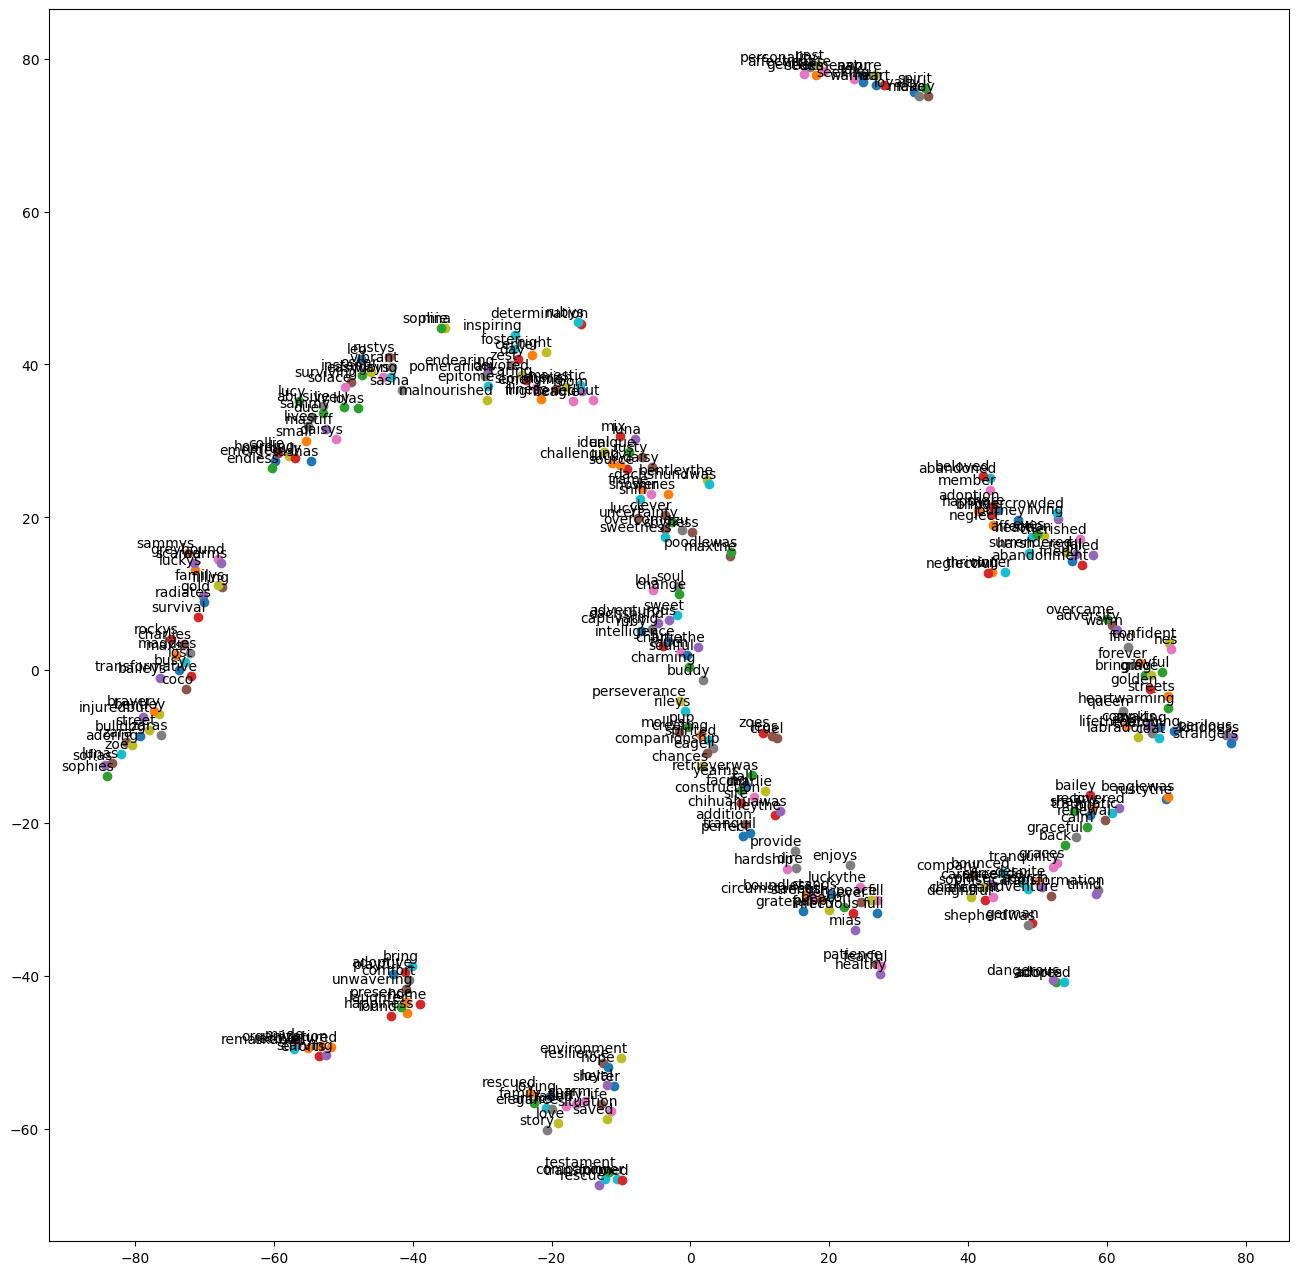

In [ ]:
tsne_plot(model)

[array([-0.16110298,  0.41385642, -0.01780242,  0.17848429,  0.22935961,
       -0.04789168,  0.12674415,  0.5318091 , -0.14337632,  0.07247812,
       -0.07830166, -0.10873806,  0.00550582,  0.09632467, -0.10908984,
        0.10533419, -0.05250598, -0.19469987, -0.12829553, -0.40457308,
       -0.32851067,  0.25446364,  0.41655335, -0.11330039, -0.08188809,
       -0.1130799 , -0.00563595, -0.3218082 , -0.3078163 ,  0.2284576 ,
        0.07012698, -0.13261227,  0.20360525, -0.17204359, -0.215128  ,
        0.5948542 , -0.16047959, -0.06393708, -0.17131014, -0.34196645,
        0.18213868, -0.14333987,  0.04877646,  0.02767226,  0.1534865 ,
       -0.1920988 , -0.18380773, -0.19340797,  0.1193301 , -0.02424165,
        0.12757957, -0.02465267, -0.15945804, -0.00255157,  0.08567258,
        0.03909456,  0.14072958, -0.19681267, -0.15224119,  0.05419568,
       -0.22216906,  0.08840581,  0.20644404, -0.21782887, -0.39179122,
        0.04062524,  0.42798093,  0.4807668 , -0.3518751 ,  0.3

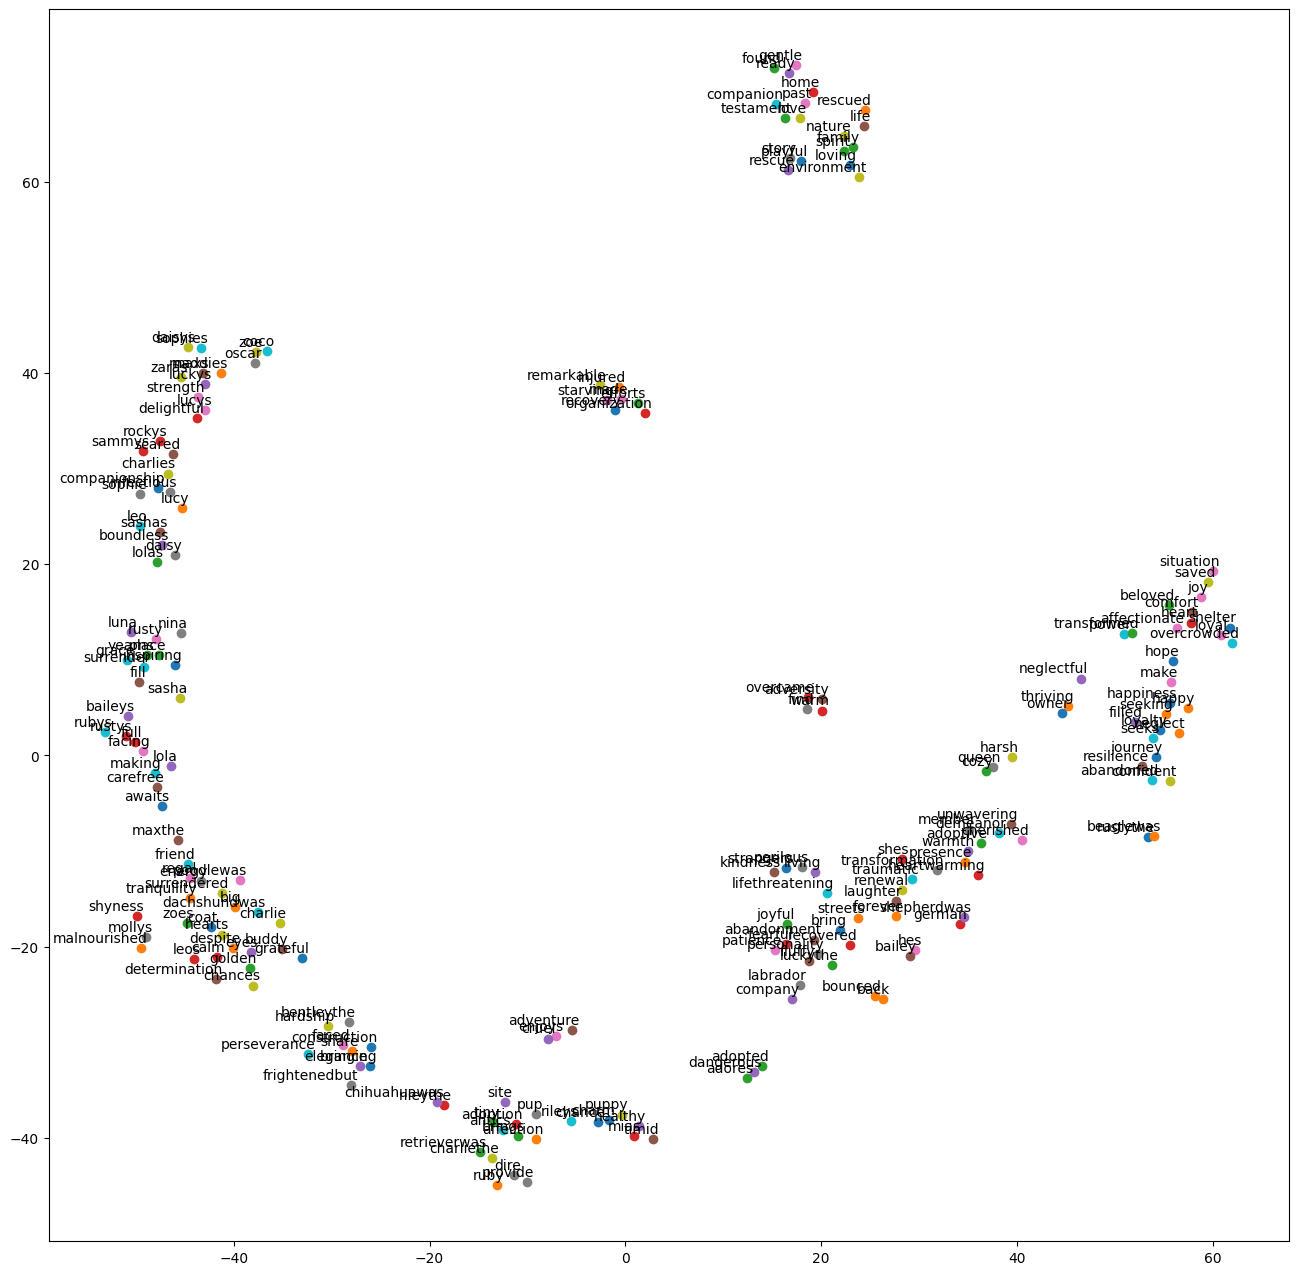

In [ ]:
# A more selective model
model = word2vec.Word2Vec(corpus, vector_size=100, window=20, min_count=10, workers=4)
tsne_plot(model)

Output streaming akan dipotong hingga 5000 baris terakhir.
        0.04260892, -0.13033853, -0.07928243, -0.01367684,  0.07686285,
       -0.04883553, -0.14736198, -0.10501134,  0.0971674 ,  0.0427121 ,
        0.09867472, -0.12797388,  0.03698712, -0.02245624, -0.02942642,
        0.017309  ,  0.03403311,  0.01062852, -0.15918534,  0.08234955,
        0.05105291, -0.02056628,  0.006411  ,  0.02628618, -0.06939851,
        0.23326321,  0.07330603,  0.20385024, -0.18579051,  0.19128217,
       -0.08849292,  0.08123434,  0.10315332, -0.04494977,  0.12321843,
        0.03967   , -0.09282915,  0.00488226, -0.02166237,  0.01651374,
       -0.16525193, -0.04943454, -0.24763331,  0.22301368, -0.04464216,
        0.044257  ,  0.20461932,  0.10237112,  0.14902478, -0.01485122,
        0.20049831,  0.08736604, -0.04154744,  0.01555064,  0.19041471,
        0.15328799,  0.0043087 , -0.11725836,  0.02385081, -0.01604173],
      dtype=float32), array([-0.03963036,  0.16203548, -0.03012162, -0.02396

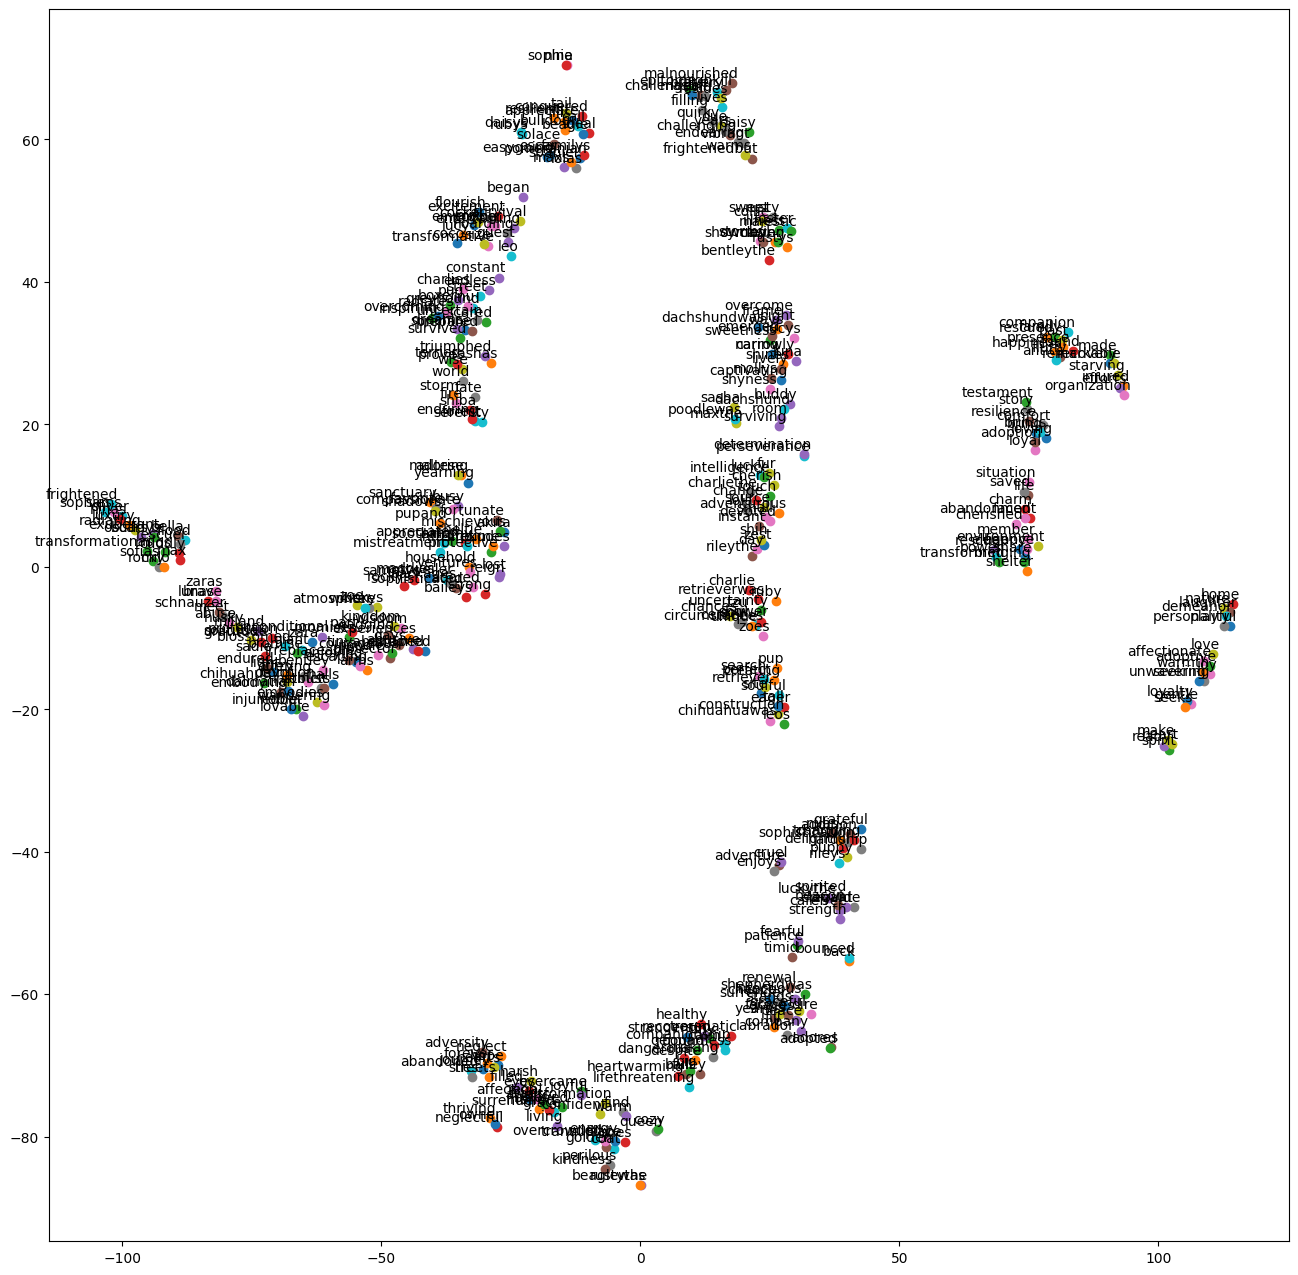

In [ ]:
# A less selective model
model = word2vec.Word2Vec(corpus, vector_size=100, window=20, min_count=3, workers=4)
tsne_plot(model)

# It's Becoming Hard to Read

With a dataset this large, its difficult to make an easy-to-read TSNE visualization. What you can do is use the model to look up the most similar words from any given point.

In [ ]:
model.wv.most_similar('nature')

[('gentle', 0.9996816515922546),
 ('demeanor', 0.9993281364440918),
 ('unwavering', 0.9993042945861816),
 ('heart', 0.9992947578430176),
 ('loyalty', 0.9992827773094177),
 ('joy', 0.9992623925209045),
 ('spirit', 0.9992480874061584),
 ('warmth', 0.999234139919281),
 ('seeking', 0.999231219291687),
 ('make', 0.9992199540138245)]

In [ ]:
model.wv.most_similar('lunas')

[('uncertainty', 0.9827876091003418),
 ('circumstances', 0.9827518463134766),
 ('hope', 0.9824904799461365),
 ('past', 0.9824701547622681),
 ('eyes', 0.9822811484336853),
 ('neglect', 0.9822787046432495),
 ('grace', 0.98226398229599),
 ('renewal', 0.9821979999542236),
 ('streets', 0.9821891188621521),
 ('presence', 0.9821837544441223)]

# The End

Good luck!